In [57]:
import os
import cv2
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os
import random
import math

def flip_image(image, flipCode):
    return cv2.flip(image, flipCode)

# Fonction pour lire les annotations
def read_annotation(file_path):
    with open(file_path, 'r') as file:
        annotations = file.readlines()
    return annotations

def flip_annotations(annotations, image_width, image_height, flipCode):
    new_annotations = []
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        if flipCode == 1:  # Flip horizontal
            x_center = 1 - x_center
        elif flipCode == 0:  # Flip vertical
            y_center = 1 - y_center
        elif flipCode == -1:  # Flip both
            x_center = 1 - x_center
            y_center = 1 - y_center
        new_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
    return new_annotations

def adjust_brightness(image, value):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


# Fonction pour écrire les nouvelles annotations
def write_annotation(new_file_path, annotations):
    with open(new_file_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def adjust_annotations_for_rotation(annotations, image_width, image_height, angle):
    new_annotations = []
    # Convertir l'angle de degrés en radians pour la rotation
    angle_rad = math.radians(angle)

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        # Convertir les coordonnées du centre en pixels
        x_center = x_center * image_width
        y_center = y_center * image_height
        bbox_width = width * image_width
        bbox_height = height * image_height

        # Calculer l'angle de rotation en fonction de l'angle donné
        if angle == 90:
            x_center_new = y_center / image_height
            y_center_new = 1 - (x_center / image_width)
        elif angle == 180:
            x_center_new = 1 - (x_center / image_width)
            y_center_new = 1 - (y_center / image_height)
        elif angle == 270:
            x_center_new = 1 - (y_center / image_height)
            y_center_new = x_center / image_width
        else:
            x_center_new = x_center / image_width
            y_center_new = y_center / image_height

        # Pour une rotation de 90 ou 270 degrés, échangez la largeur et la hauteur de la boîte englobante
        if angle in [90, 270]:
            width_new = bbox_height / image_width
            height_new = bbox_width / image_height
        else:
            width_new = bbox_width / image_width
            height_new = bbox_height / image_height

        # Ajouter la nouvelle annotation à la liste
        new_annotations.append(f"{class_id} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    return new_annotations

# Appliquer une transformation aléatoire à une image
def apply_random_transformation(image, annotations, transformation_type):
    if transformation_type == 'flip':
        flipCode = random.choice([-1, 0, 1])
        transformed_image = flip_image(image, flipCode)
        transformed_annotations = flip_annotations(annotations, image.shape[1], image.shape[0], flipCode)
    elif transformation_type == 'brightness':
        brightness_value = random.randint(-50, 50)
        transformed_image = adjust_brightness(image, brightness_value)
        transformed_annotations = annotations
    elif transformation_type == 'rotate':
        angle = random.choice([0, 90, 180, 270])  # Choix aléatoire d'angle
        transformed_image = rotate_image(image, angle)
        transformed_annotations = adjust_annotations_for_rotation(annotations, image.shape[1], image.shape[0], angle)
    return transformed_image, transformed_annotations

def process_images_annotations(images_directory, annotations_directory, new_base_directory, transformations_dict, subset_type):
    new_images_count = 0
    files = [f for f in os.listdir(images_directory) if f.endswith(".jpg")]
    random.shuffle(files)

    # Définition des chemins pour les sous-dossiers 'images' et 'labels'
    subset_images_directory = os.path.join(new_base_directory, subset_type, "images")
    subset_annotations_directory = os.path.join(new_base_directory, subset_type, "labels")
    os.makedirs(subset_images_directory, exist_ok=True)
    os.makedirs(subset_annotations_directory, exist_ok=True)

    for filename in files:
        file_path = os.path.join(images_directory, filename)
        annotation_path = os.path.join(annotations_directory, filename.replace('.jpg', '.txt'))
        image = cv2.imread(file_path)
        annotations = read_annotation(annotation_path)

        for transformation_type, num_times in transformations_dict.items():
            for _ in range(num_times):
                transformed_image, transformed_annotations = apply_random_transformation(image, annotations, transformation_type)

                # Utiliser les sous-dossiers pour enregistrer les fichiers transformés
                new_image_file = os.path.join(subset_images_directory, f"{transformation_type}_image_{new_images_count}.jpg")
                new_annotation_file = os.path.join(subset_annotations_directory, f"{transformation_type}_annotation_{new_images_count}.txt")

                cv2.imwrite(new_image_file, transformed_image)
                write_annotation(new_annotation_file, transformed_annotations)
                new_images_count += 1

# Dossiers pour le dataset original
base_directory = "raw_data/EpicureAi.v8i.yolov8/"
train_images_directory = os.path.join(base_directory, "train/images")
train_annotations_directory = os.path.join(base_directory, "train/labels")
validation_images_directory = os.path.join(base_directory, "valid/images")
validation_annotations_directory = os.path.join(base_directory, "valid/labels")

# Chemins pour le nouveau dataset
new_dataset_directory = "raw_data/new_dataset"
new_train_directory = os.path.join(new_dataset_directory, "train")
new_valid_directory = os.path.join(new_dataset_directory, "valid")

# Nombre d'images dans les ensembles d'entraînement et de validation (à mettre à jour)
num_train_images = 125  # Mettre à jour avec le nombre réel d'images d'entraînement
num_valid_images = 54   # Mettre à jour avec le nombre réel d'images de validation
total_images = num_train_images + num_valid_images
num_transformations = 3000  # Nombre total d'images transformées souhaitées
transformations_per_image = num_transformations // total_images

# Définir le nombre de fois que chaque transformation doit être appliquée
transformations_dict = {
    'flip': transformations_per_image // 3,
    'brightness': transformations_per_image // 3,
    'rotate': transformations_per_image // 3
}

# Appliquer les transformations sur l'ensemble d'entraînement
process_images_annotations(train_images_directory, train_annotations_directory, new_dataset_directory, transformations_dict, "train")

# Ajuster les transformations pour l'ensemble de validation si nécessaire
transformations_dict['flip'] += transformations_per_image % 3
process_images_annotations(validation_images_directory, validation_annotations_directory, new_dataset_directory, transformations_dict, "valid")


In [58]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Chemin du nouveau dataset
new_dataset_directory = "raw_data/new_dataset"

# Compter les fichiers pour chaque sous-ensemble et type (images ou labels)
for subset in ["train", "valid"]:
    for file_type in ["images", "labels"]:
        directory = os.path.join(new_dataset_directory, subset, file_type)
        num_files = count_files(directory)
        print(f"Nombre de {file_type} dans {subset}: {num_files}")


Nombre de images dans train: 1875
Nombre de labels dans train: 1875
Nombre de images dans valid: 864
Nombre de labels dans valid: 864


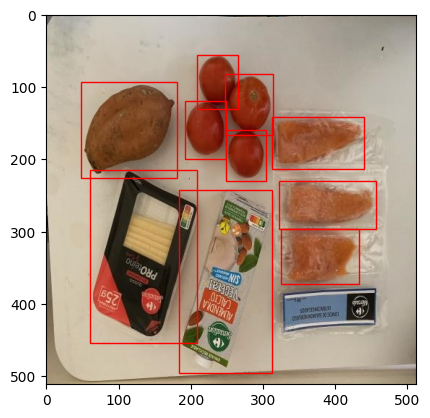

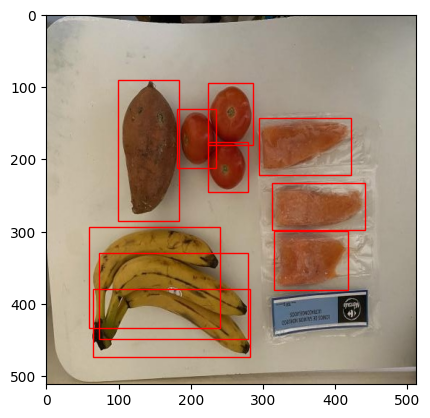

In [66]:
def show_image_with_annotations(image_file, annotation_file):
    # Vérifier si les fichiers existent
    if not os.path.isfile(image_file) or not os.path.isfile(annotation_file):
        print(f"L'un des fichiers spécifiés n'existe pas: {image_file} ou {annotation_file}")
        return

    # Lire l'image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB

    # Lire les annotations
    with open(annotation_file, 'r') as file:
        annotations = [line.strip() for line in file if line.strip()]

    # Afficher l'image et les boîtes englobantes
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x_center *= image.shape[1]
        y_center *= image.shape[0]
        width *= image.shape[1]
        height *= image.shape[0]
        rect = patches.Rectangle(
            (x_center - width / 2, y_center - height / 2),
            width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Choix d'un ensemble de données (train ou valid) pour afficher une image
chosen_subset = "train"  # ou "valid"

# Utilisation de la fonction avec des chemins de fichiers mis à jour
show_images_directory = os.path.join(new_dataset_directory, chosen_subset, "images")
show_annotations_directory = os.path.join(new_dataset_directory, chosen_subset, "labels")

# Exemple d'utilisation avec un fichier spécifique
sample_image_file = os.path.join(show_images_directory, "rotate_image_1813.jpg")
sample_annotation_file = os.path.join(show_annotations_directory, "rotate_annotation_1813.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)

# Choix d'un ensemble de données (train ou valid) pour afficher une image
chosen_subset = "valid"  # ou "valid"

# Utilisation de la fonction avec des chemins de fichiers mis à jour
show_images_directory = os.path.join(new_dataset_directory, chosen_subset, "images")
show_annotations_directory = os.path.join(new_dataset_directory, chosen_subset, "labels")

# Exemple d'utilisation avec un fichier spécifique
sample_image_file = os.path.join(show_images_directory, "rotate_image_379.jpg")
sample_annotation_file = os.path.join(show_annotations_directory, "rotate_annotation_379.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)


In [67]:
!git status


On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .DS_Store
	modified:   Test generate image.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [68]:
! git add .


In [69]:
!git commit -m 'new_data augmentation'


[master 8352c42] new_data augmentation
 2 files changed, 594 insertions(+), 21 deletions(-)


In [2]:
!git pull origin master


remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 22 (delta 4), reused 6 (delta 4), pack-reused 15
Unpacking objects: 100% (22/22), 5.70 MiB | 1.24 MiB/s, done.
From github.com:monsieurgoodmood/EpicureAi
 * branch            master     -> FETCH_HEAD
   8352c42..db765c3  master     -> origin/master
Updating 8352c42..db765c3
Fast-forward
 .gitignore                                    |    2 +
 EpicureAi                                     |    1 -
 EpicureAi_code/recipes_chatgpt.py             |   11 +
 EpicureAi_code/ultralytics.py                 |    9 +
 data/copies_folder/brocolli2_copy_1.png       |  Bin 90826 -> 0 bytes
 data/copies_folder/brocolli2_copy_10.png      |  Bin 90826 -> 0 bytes
 data/copies_folder/brocolli2_copy_2.png       |  Bin 90826 -> 0 bytes
 data/copies_folder/brocolli2_copy_3.png       |  Bin 90826 -> 0 bytes
 data/copies_folder/brocolli2_copy_4.png       |  Bin 90826 

In [3]:
!git push origin master


Everything up-to-date
